#ANALYZING MTA SUBWAY DATA

In this project, I will analyze a sample of the MTA New York City Subway data from May 2015. The data contains hourly entries and exits for turnstiles in the subway system. There is also a weather dataset for NYCm gathered from weather underground,corresponding to the turnstile data. The question that I am trying to answer is "Does a change in weather significantly affect the amount of NYC subway traffic?"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sets import Set

%matplotlib inline
pd.options.display.mpl_style = 'default'

## Loading the Data

The data gathering process is detailed in the other two notebooks.

In [244]:
df_weather = pd.read_csv('data/final/weather_final.csv')
df_weather.head(1)

,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,snow,...,thunder,tornado,vism,wdird,wgustm,windchillm,wspdm,time_n,date_n,weekday
0,Clear,15,0,0,-9999,64,-9999,1014,0,0,...,0,0,16.1,260,-9999,-999,24.1,00:53:00,2015-05-01,4


In [260]:
df_turnstile = pd.read_csv('data/final/turnstile_final.csv')
df_turnstile.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,time_n,DESCn,ENTRIESn_hourly,EXITSn_hourly,date_n,weekday
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,00:00:00,REGULAR,242,27,2015-05-01,4


## Exploratory Data Analysis

Firstly, the data was looked at in terms of days and dates. I was careful to note that some days will be occuring more than others, which will be important when looking at data on a per day or weekend vs weekday basis. In python's datetime module 0 represents a Monday.

The breakdown is like so

Monday    - 4 days 

Tuesday   - 4 days

Wednesday - 4 days

Thursday  - 4 days

Friday    - 5 days

Saturday  - 5 days

Sunday    - 5 days

###Weather Data

In [236]:
df_weather.groupby(['weekday', 'date_n']).count()

conds  dewptm  fog  hail  heatindexm  hum  precipm  \
weekday date_n                                                           
0       2015-05-04     24      24   24    24          24   24       24   
        2015-05-11     27      27   27    27          27   27       27   
        2015-05-18     39      39   39    39          39   39       39   
        2015-05-25     44      44   44    44          44   44       44   
1       2015-05-05     27      27   27    27          27   27       27   
        2015-05-12     35      35   35    35          35   35       35   
        2015-05-19     35      35   35    35          35   35       35   
        2015-05-26     32      32   32    32          32   32       32   
2       2015-05-06     29      29   29    29          29   29       29   
        2015-05-13     32      32   32    32          32   32       32   
        2015-05-20     24      24   24    24          24   24       24   
        2015-05-27     34      34   34    34          34   34       34   
3       2015-05-07     31      31   31    31          31   31       31   
        2015-05-14     27      27   27    27          27   27       27   
        2015-05-21     31      31   31    31          31   31       31   
        2015-05-28     29      29   29    29          29   29       29   
4       2015-05-01     24      24   24    24          24   24       24   
        2015-05-08     24      24   24    24          24   24       24   
        2015-05-15     32      32   32    32          32   32       32   
        2015-05-22     30      30   30    30          30   30       30   
        2015-05-29     26      26   26    26          26   26       26   
5       2015-05-02     24      24   24    24          24   24       24   
        2015-05-09     24      24   24    24          24   24       24   
        2015-05-16     31      31   31    31          31   31       31   
        2015-05-23     24      24   24    24          24   24       24   
        2015-05-30     28      28   28    28          28   28       28   
6       2015-05-03     24      24   24    24          24   24       24   
        2015-05-10     26      26   26    26          26   26       26   
        2015-05-17     33      33   33    33          33   33       33   
        2015-05-24     31      31   31    31          31   31       31   
        2015-05-31     43      43   43    43          43   43       43   

                    pressurem  rain  snow  tempm  thunder  tornado  vism  \
weekday date_n                                                             
0       2015-05-04         24    24    24     24       24       24    24   
        2015-05-11         27    27    27     27       27       27    27   
        2015-05-18         39    39    39     39       39       39    39   
        2015-05-25         44    44    44     44       44       44    44   
1       2015-05-05         27    27    27     27       27       27    27   
        2015-05-12         35    35    35     35       35       35    35   
        2015-05-19         35    35    35     35       35       35    35   
        2015-05-26         32    32    32     32       32       32    32   
2       2015-05-06         29    29    29     29       29       29    29   
        2015-05-13         32    32    32     32       32       32    32   
        2015-05-20         24    24    24     24       24       24    24   
        2015-05-27         34    34    34     34       34       34    34   
3       2015-05-07         31    31    31     31       31       31    31   
        2015-05-14         27    27    27     27       27       27    27   
        2015-05-21         31    31    31     31       31       31    31   
        2015-05-28         29    29    29     29       29       29    29   
4       2015-05-01         24    24    24     24       24       24    24   
        2015-05-08         24    24    24     24       24       24    24   
        2015-05-15         32    32    32     32       32

On further inspection of the above table, I noticed that quite a lot of days had more than the 24 observations I expected from a quick look at the first 50 columns or so. I checked the wunderground site again and found this bit of information.

"Almost 2,000 Automated Surface Observation System (ASOS) stations located at airports throughout the country. These are maintained by the Federal Aviation Administration and observations are updated hourly, or more frequently when adverse weather affecting aviation occurs (low visibility, precipitation, etc)."

My first reaction was to simply remove these observations since the desynch between turnstile and weather datasets is already troublesome. The irregularity of the time series and extra rows may make plotting the data and doing computations may add to that. But these rows may also be the most important thing in the entire dataset - adverse weather that affects aviation may strongly correlate with that which changes subway traffic behaviour.

I decided to pick a few rows from the first day the irregularity occurs and see if the regular rows before and after the irregular one adequetely cover the change in weather conditions.

In [152]:
df_day_not24 = df_weather[df_weather.date_n == "2015-05-11"]
df_day_not24 = df_day_not24.reset_index()
df_day_not24

,index,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,...,thunder,tornado,vism,wdird,wgustm,windchillm,wspdm,time_n,date_n,weekday
0,257,Clear,21.7,0,0,-9999.0,79,-9999,1016.1,0,...,0,0,16.1,140,-9999.0,-999,16.7,00:53:00,2015-05-11,0
1,258,Clear,21.7,0,0,-9999.0,82,-9999,1015.8,0,...,0,0,16.1,160,-9999.0,-999,16.7,01:53:00,2015-05-11,0
2,259,Clear,21.7,0,0,-9999.0,82,-9999,1015.2,0,...,0,0,16.1,160,-9999.0,-999,20.4,02:53:00,2015-05-11,0
3,260,Clear,22.0,0,0,-9999.0,83,-9999,1015.8,0,...,0,0,16.1,150,-9999.0,-999,14.8,03:53:00,2015-05-11,0
4,261,Partly Cloudy,22.2,0,0,-9999.0,84,-9999,1015.6,0,...,0,0,16.1,170,-9999.0,-999,13.0,04:53:00,2015-05-11,0
5,262,Mostly Cloudy,22.2,0,0,-9999.0,81,-9999,1016.5,0,...,0,0,16.1,160,-9999.0,-999,14.8,05:22:00,2015-05-11,0
6,263,Scattered Clouds,22.2,0,0,-9999.0,84,-9999,1016.8,0,...,0,0,14.5,170,-9999.0,-999,13.0,05:44:00,2015-05-11,0
7,264,Partly Cloudy,22.2,0,0,-9999.0,84,-9999,1015.9,0,...,0,0,14.5,160,-9999.0,-999,13.0,05:53:00,2015-05-11,0
8,265,Clear,22.2,0,0,-9999.0,81,-9999,1016.8,0,...,0,0,12.9,160,-9999.0,-999,11.1,06:53:00,2015-05-11,0
9,266,Mostly Cloudy,22.8,0,0,29.0,79,-9999,1017.5,0,...,0,0,12.9,160,-9999.0,-999,14.8,07:53:00,2015-05-11,0


In [261]:
def get_relevant_times(df):
    """
    
    Returns indices of interest for analyzing irregular intervals.
    
    """
    
    # Series of each observation's minute.
    minute = (pd.to_datetime(df['time_n']))
    minute_filter = pd.Series([n.minute for n in minute])
    
    #print minute_filter
    
    # Find the irregular intervals.
    irreg_rows = df.loc[minute_filter != 53]
    
    return irreg_rows.index.values

In [262]:
def print_full(x):
    """
    Prints all the columns.
    """
    pd.set_option('display.max_columns', (x).shape[1])
    print(x)
    pd.reset_option('display.max_columns')

In [263]:
relevant_times = list(get_relevant_times(df_day_not24))
relevant_times

# Add the irregular, before and after.
relevant_times = Set([])
    
for each in irreg_times:
    relevant_times.update([each-1, each, each+1])

In [264]:
irreg_times

array([ 5,  6, 10], dtype=int64)

In [265]:
print_full(df_day_not24.loc[relevant_times])

    index             conds  dewptm  fog  hail  heatindexm  hum  precipm  \
4     261     Partly Cloudy    22.2    0     0     -9999.0   84    -9999   
5     262     Mostly Cloudy    22.2    0     0     -9999.0   81    -9999   
6     263  Scattered Clouds    22.2    0     0     -9999.0   84    -9999   
7     264     Partly Cloudy    22.2    0     0     -9999.0   84    -9999   
9     266     Mostly Cloudy    22.8    0     0        29.0   79    -9999   
10    267  Scattered Clouds    22.2    0     0        29.6   74    -9999   
11    268  Scattered Clouds    22.2    0     0        29.6   74    -9999   

    pressurem  rain  snow  tempm  thunder  tornado  vism  wdird  wgustm  \
4      1015.6     0     0   25.0        0        0  16.1    170   -9999   
5      1016.5     0     0   25.6        0        0  16.1    160   -9999   
6      1016.8     0     0   25.0        0        0  14.5    170   -9999   
7      1015.9     0     0   25.0        0        0  14.5    160   -9999   
9      1017.5   

Looking at the above table, with the first 4 rows as one "block" and the next 3 as another, it's difficult to see any huge difference. On 2015-05-11 there are two extra observations between 04:53:00 and 05:53:00, with one more extra observation between 07:53:00 and 08:53:00.

I think in both blocks the biggest differences are windspeed (13 - 14.8 - 13 - 13) (14.8 - 11.1 - 13.0) and visibility (16.1 - 16.1 - 14.5) (12.9 - 14.5 - 14.5). These are obviously very important factors for aircrafts but I'm unsure of how important they are for pedestrians considering taking the subway.

Without any deep domain knowledge in meteorlogy the first descriptive attribute "conds" may be my best bet here. It does indeed have a change from partly cloudy to mostly to scattered and back to partly again. However I don't think it's that indicative of a significant change or insightful, especially since it goes through 3 changes in an hour before returning to its original value. So I'm going to draw a line in the sand and drop these extra data points.

In [245]:
relevant_times2 = get_relevant_times(df_weather)

0     53
1     53
2     53
3     53
4     53
5     53
6     53
7     53
8     53
9     53
10    53
11    53
12    53
13    53
14    53
...
909    36
910    46
911    53
912     7
913    18
914    24
915    53
916    53
917    53
918    53
919    53
920    53
921    53
922    53
923    53
Length: 924, dtype: int64


### Dropping Rows

In [246]:
df_weather = df_weather.drop(relevant_times2)

In [248]:
df_weather.groupby(['weekday', 'date_n']).mean()


dewptm  fog  hail   heatindexm        hum      precipm  \
weekday date_n                                                                  
0       2015-05-04  17.366667    0     0 -7074.579167  65.291667 -7915.875000   
        2015-05-11  21.295833    0     0 -5819.283333  71.750000 -7915.875000   
        2015-05-18  21.950000    0     0 -5401.237500  74.166667 -9581.804167   
        2015-05-25  21.829167    0     0 -7073.116667  76.291667 -4580.979167   
1       2015-05-05  17.341667    0     0 -7492.270833  65.083333 -9999.000000   
        2015-05-12  22.012500    0     0 -3730.058333  72.375000 -8749.125000   
        2015-05-19  20.929167    0     0 -4566.062500  69.708333 -9999.000000   
        2015-05-26  20.808333    0     0 -2894.779167  71.708333 -7081.837500   
2       2015-05-06  19.079167    0     0 -8327.820833  72.250000 -8749.037500   
        2015-05-13  20.979167    0     0 -4565.975000  68.125000 -9165.750000   
        2015-05-20  21.979167    0     0 -2893.000000  67.833333 -9999.000000   
        2015-05-27  21.241667    0     0 -4984.333333  72.416667 -8748.762500   
3       2015-05-07  19.204167    0     0 -5820.512500  68.958333 -9999.000000   
        2015-05-14  21.825000    0     0 -2476.379167  69.666667 -9999.000000   
        2015-05-21  21.820833    0     0 -2893.916667  70.750000 -7915.516667   
        2015-05-28  21.475000    0     0 -2893.783333  68.458333 -9999.000000   
4       2015-05-01  12.954167    0     0 -9999.000000  50.708333 -9999.000000   
        2015-05-08  18.837500    0     0 -5402.445833  64.916667 -9999.000000   
        2015-05-15  22.179167    0     0 -4566.337500  76.083333 -7082.508333   
        2015-05-22  18.008333    0     0 -6656.520833  66.583333 -9582.375000   
        2015-05-29  20.908333    0     0 -3312.050000  65.583333 -9999.000000   
5       2015-05-02  13.050000    0     0 -8745.766667  52.583333 -9999.000000   
        2015-05-09  19.900000    0     0 -4984.545833  67.333333 -9999.000000   
        2015-05-16  22.200000    0     0 -2475.204167  68.958333 -9165.750000   
        2015-05-23  20.304167    0     0 -3312.333333  63.750000 -9582.362500   
        2015-05-30  21.029167    0     0 -3312.541667  67.666667 -9582.333333   
6       2015-05-03  13.970833    0     0 -8328.008333  56.750000 -9999.000000   
        2015-05-10  20.270833    0     0 -4566.141667  66.791667 -9999.000000   
        2015-05-17  22.545833    0     0    32.362500  68.000000 -9999.000000   
        2015-05-24  22.029167    0     0  -803.795833  66.833333 -9165.704167   
        2015-05-31  20.550000    0     0 -7073.912500  74.000000 -7081.154167   

                      pressurem      rain  snow      tempm   thunder  tornado  \
weekday date_n                                                                  
0       2015-05-04  1020.179167  0.125000     0  24.437500  0.000000        0   
        2015-05-11  1017.541667  0.125000     0  26.991667  0.000000        0   
        2015-05-18  1019.937500  0.041667     0  27.058333  0.083333        0   
        2015-05-25  1017.058333  0.291667     0  26.354167  0.083333        0   
1       2015-05-05  1020.100000  0.000000     0  24.433333  0.000000        0   
        2015-05-12  1020.220833  0.125000     0  27.458333  0.000000        0   
        2015-05-19  1017.925000  0.000000     0  27.012500  0.000000        0   
        2015-05-26  1018.283333  0.125000     0  26.466667  0.000000        0   
2       2015-05-06  1017.354167  0.083333     0  24.479167  0.000000        0   
        2015-05-13  1020.179167  0.000000     0  27.487500  0.000000        0   
        2015-05-20  1015.316667  0.000000     0  28.625000  0.000000        0   
        2015-05-27  1019.095833  0.083333     0  26.675000  0.000000        0   
3       2015-05-07  1016.658333  0.000000     0  25.645833  0.000000        0   
        2015-05-14  1019.154167  0.000000     0  28.000000  0.000000        0   
        2015-05-21  1016.233333  0.125000     0  27.7

###Subway Data

In [271]:
df_turnstile.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,time_n,DESCn,ENTRIESn_hourly,EXITSn_hourly,date_n,weekday
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,00:00:00,REGULAR,242,27,2015-05-01,4
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04:00:00,REGULAR,19,5,2015-05-01,4
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08:00:00,REGULAR,44,88,2015-05-01,4
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,12:00:00,REGULAR,154,142,2015-05-01,4
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,16:00:00,REGULAR,320,23,2015-05-01,4
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,20:00:00,REGULAR,885,19,2015-05-01,4
6,A002,R051,02-00-01,LEXINGTON AVE,NQR456,BMT,00:00:00,REGULAR,229,25,2015-05-01,4
7,A002,R051,02-00-01,LEXINGTON AVE,NQR456,BMT,04:00:00,REGULAR,15,1,2015-05-01,4
8,A002,R051,02-00-01,LEXINGTON AVE,NQR456,BMT,08:00:00,REGULAR,43,38,2015-05-01,4
9,A002,R051,02-00-01,LEXINGTON AVE,NQR456,BMT,12:00:00,REGULAR,165,75,2015-05-01,4


In [270]:
df_turnstile.groupby(['weekday', 'date_n', 'UNIT', 'C/A', 'SCP']).count()

STATION  LINENAME  DIVISION  time_n  \
weekday date_n     UNIT C/A   SCP                                             
0       2015-05-04 R001 A058  01-00-00        6         6         6       6   
                              01-00-01        6         6         6       6   
                              01-00-02        6         6         6       6   
                              01-00-03        6         6         6       6   
                              01-06-00        6         6         6       6   
                              01-06-01        6         6         6       6   
                              01-06-02        6         6         6       6   
                        A060  00-00-00        6         6         6       6   
                              00-00-01        6         6         6       6   
                              00-00-02        6         6         6       6   
                              00-00-03        6         6         6       6   
                              00-00-04        6         6         6       6   
                              00-00-05        6         6         6       6   
                              00-00-06        6         6         6       6   
                              00-00-07        6         6         6       6   
                        R101  02-00-00        6         6         6       6   
                              02-00-01        6         6         6       6   
                              02-00-02        6         6         6       6   
                              02-00-03        6         6         6       6   
                              02-00-04        6         6         6       6   
                              02-00-05        6         6         6       6   
                              02-00-06        6         6         6       6   
                              02-00-07        6         6         6       6   
                              02-00-08        6         6         6       6   
                              02-06-00        6         6         6       6   
                              02-06-01        6         6         6       6   
                              02-07-00        6         6         6       6   
                              02-07-01        6         6         6       6   
                              02-07-02        6         6         6       6   
                              02-07-03        6         6         6       6   
...                                         ...       ...       ...     ...   
6       2015-05-31 R551 PTH04 00-00-05        5         5         5       5   
                              00-00-06        6         6         6       6   
                              00-01-00        6         6         6       6   
                              00-01-01        6         6         6       6   
                              00-01-02        5         5         5       5   
                              00-01-03        5         5         5       5   
                              00-01-05        5         5         5       5   
                              00-04-00        6         6         6       6   
                              00-04-01        6         6         6       6   
                              00-04-02        6         6         6       6   
                              00-04-03        5         5         5       5   
                              00-04-04        5         5         5       5   
                              00-04-05        6         6         6       6   
                   R552 PTH03 00-00-00        6         6         6       6   
                              00-00-01        6         6         6       6   
                              00-00-02        6         6         6       6   
                              00-00-03        6         6         6       6   
                              00-00-04        6         6         6       6   
           

The turnstiles each have 6 entries per day which is what we would expect given that they write their records every 4 hours. Some of the turnstiles, which start recording at 1am for some reason, are missing one entry (as it would technically be 1am of the next day). I'll ignore it for now but keep it in the back of my mind. In the future I could improve this analysis by downloading the files from the MTA website for June and putting the very first entry for the turnstiles in question into the dataframe.

In [277]:
df_turnstile.tail(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,time_n,DESCn,ENTRIESn_hourly,EXITSn_hourly,date_n,weekday
850333,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09:00:00,REGULAR,0,0,2015-05-30,5
850334,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,13:00:00,REGULAR,0,0,2015-05-30,5
850335,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,17:00:00,REGULAR,0,0,2015-05-30,5
850336,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,21:00:00,REGULAR,0,0,2015-05-30,5
850337,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,01:00:00,REGULAR,0,0,2015-05-31,6
850338,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05:00:00,REGULAR,0,0,2015-05-31,6
850339,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09:00:00,REGULAR,0,0,2015-05-31,6
850340,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,13:00:00,REGULAR,0,0,2015-05-31,6
850341,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,17:00:00,REGULAR,0,0,2015-05-31,6
850342,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,21:00:00,REGULAR,0,0,2015-05-31,6


I'm finally confident that there are no major faults with the data and I can go ahead with some quick analysis.

### Creating a Summarization DF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002E4C5208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015D0BDA0>]], dtype=object)

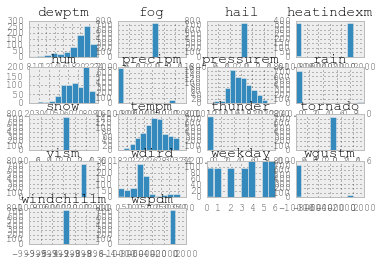

In [250]:
df_weather.hist()

In [291]:
df_turnstile.groupby(['weekday', 'date_n', 'UNIT', 'C/A', 'SCP']).sum()['ENTRIESn_hourly']

weekday  date_n      UNIT  C/A   SCP     
0        2015-05-04  R001  A058  01-00-00     835
                                 01-00-01     947
                                 01-00-02     823
                                 01-00-03     760
                                 01-06-00     213
                                 01-06-01     351
                                 01-06-02      84
                           A060  00-00-00    2437
                                 00-00-01    1864
                                 00-00-02    1390
                                 00-00-03     991
                                 00-00-04     855
                                 00-00-05    1010
                                 00-00-06    1349
                                 00-00-07    1473
...
6        2015-05-31  R552  PTH03  00-00-02     459
                                  00-00-03     474
                                  00-00-04     745
                                  00-00-05     582


In [297]:
df_turnstile.groupby('weekday').describe()

ENTRIESn_hourly  EXITSn_hourly
weekday                                      
0       count     1.096370e+05   1.096370e+05
        mean     -6.042945e+03   1.058468e+04
        std       5.785334e+06   6.047228e+06
        min      -1.825626e+09  -1.291600e+09
        25%       1.100000e+01   8.000000e+00
        50%       7.900000e+01   5.400000e+01
        75%       2.540000e+02   1.710000e+02
        max       3.676543e+08   1.397904e+09
1       count     1.104620e+05   1.104620e+05
        mean      1.341687e+04   1.750906e+04
        std       3.250877e+06   3.392512e+06
        min      -5.259447e+06  -9.854480e+05
        25%       1.300000e+01   1.000000e+01
        50%       1.020000e+02   6.700000e+01
        75%       3.120000e+02   2.080000e+02
        max       1.036157e+09   7.352539e+08
2       count     1.106910e+05   1.106910e+05
        mean      1.686978e+04   1.152752e+04
        std       5.839068e+06   3.731670e+06
        min      -5.033165e+07  -1.677736e+07
        25%       1.500000e+01   1.100000e+01
        50%       1.060000e+02   6.900000e+01
        75%       3.210000e+02   2.140000e+02
        max       1.941360e+09   1.240969e+09
3       count     1.100370e+05   1.100370e+05
        mean     -9.298643e+03  -4.741695e+03
        std       5.731819e+06   4.272974e+06
        min      -1.825652e+09  -1.291627e+09
        25%       1.500000e+01   1.100000e+01
        50%       1.080000e+02   7.000000e+01
        75%       3.240000e+02   2.150000e+02
        max       4.345280e+08   5.347642e+08
4       count     1.369970e+05   1.369970e+05
        mean      1.607106e+04   9.290207e+03
        std       4.045851e+06   2.767070e+06
        min      -1.346667e+07  -1.111348e+07
        25%       1.600000e+01   1.200000e+01
        50%       1.110000e+02   7.300000e+01
        75%       3.250000e+02   2.160000e+02
        max       1.153104e+09   9.964743e+08
5       count     1.363390e+05   1.363390e+05
        mean     -1.724666e+04  -3.198172e+04
        std       9.598063e+07   8.580040e+07
        min      -2.108209e+09  -2.087330e+09
        25%       2.000000e+00   3.000000e+00
        50%       5.900000e+01   4.300000e+01
        75%       2.320000e+02   1.680000e+02
        max       2.104710e+09   2.087387e+09
6       count     1.361800e+05   1.361800e+05
        mean     -8.560778e+02   1.307018e+02
        std       3.644947e+05   1.615152e+04
        min      -1.344799e+08  -3.449750e+05
        25%       7.000000e+00   6.000000e+00
        50%       5.100000e+01   3.600000e+01
        75%       1.520000e+02   1.110000e+02
        max       2.637128e+06   5.947602e+06

weekday
0          [[Axes(0.125,0.125;0.775x0.775)]]
1          [[Axes(0.125,0.125;0.775x0.775)]]
2          [[Axes(0.125,0.125;0.775x0.775)]]
3          [[Axes(0.125,0.125;0.775x0.775)]]
4          [[Axes(0.125,0.125;0.775x0.775)]]
5          [[Axes(0.125,0.125;0.775x0.775)]]
6          [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

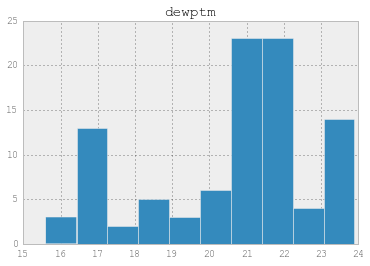

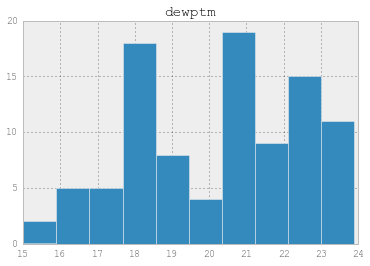

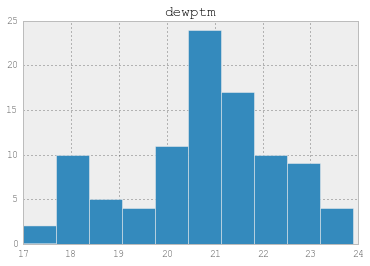

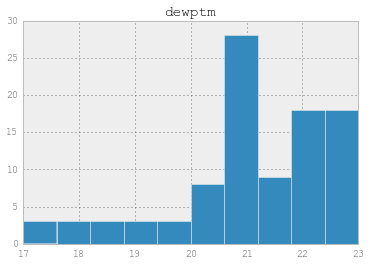

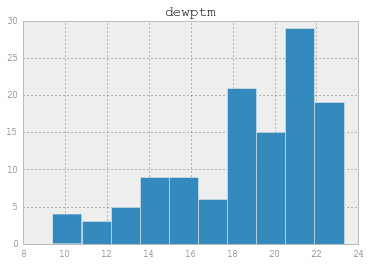

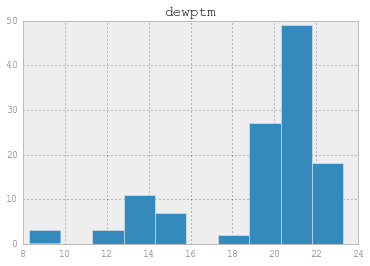

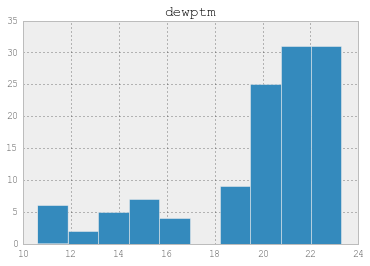

In [287]:
#df_weather['hail'].groupby('weekday').hist()
a = df_weather[['dewptm', 'weekday']]
a.groupby('weekday').hist()

In [256]:
df_turnstile.ENTRIESn_hourly.groupby('weekday').hist()

KeyError: 'weekday'

weekday
0          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
1          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
2          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
3          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
4          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
5          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
6          [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
dtype: object

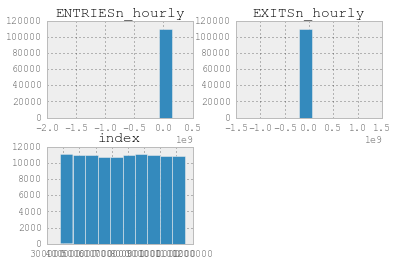

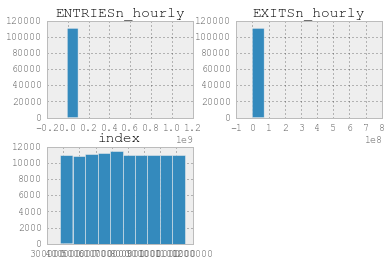

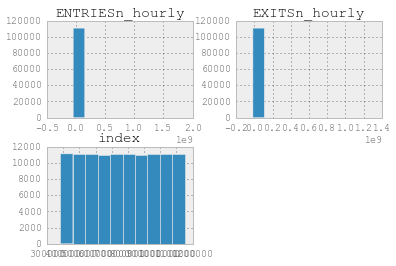

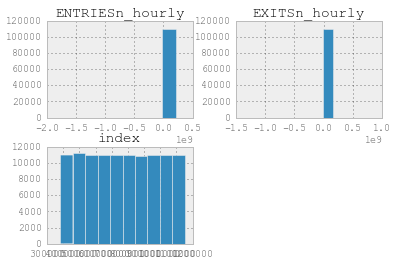

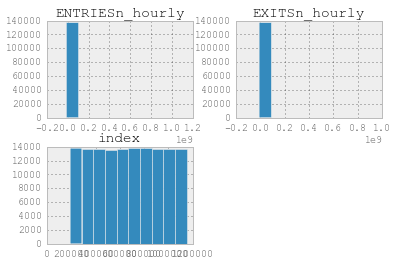

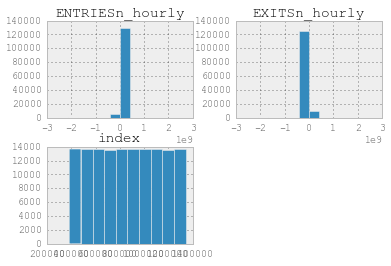

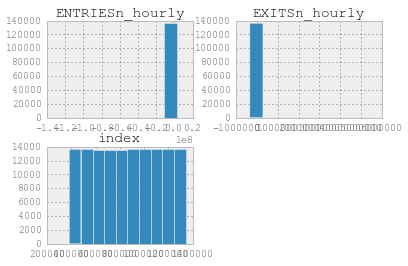

In [258]:
#df_turnstile.groupby('weekday').hist()

### Total Ridership for Each Day of the Week

## Statistical Test

The data was analyzed with the Mann-Whitney U-Test. A two-tail p-value was used as no prior assumptions are made about the contrast in the distributions of ridership on rainy and non-rainy days. The p-value returned by scipy.stats.mannwhitneyu is one-tailed as noted here:
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html. In order to use a two-tailed test, the one-tailed p-value returned by scipy.stats.mannwhitneyu must be multiplied by 2.

The significance level being used in this test is 0.05 (i.e. 5% chance of observing a result as least as extreme).

\begin{align*}
   H_0 & : Response\ and\ explanatory\ variable\ are\ independent
   \\
   H_a & :Response\ and\ explanatory\ variable\ are\ dependent
\end{align*}

##Rainy Days

In [71]:
# Get the rainy days.
rain_filter = df_weather_master['rain'] == 1
day_rain = pd.Series(df_weather_master[rain_filter].date_n.ravel()).unique()
day_rain

array(['2015-05-04', '2015-05-06', '2015-05-11', '2015-05-12',
       '2015-05-15', '2015-05-16', '2015-05-18', '2015-05-21',
       '2015-05-24', '2015-05-25', '2015-05-26', '2015-05-27',
       '2015-05-30', '2015-05-31'], dtype=object)

In [73]:
day_rain[0]

'2015-05-04'

In [ ]:
df_turnstile_master

In [72]:
# Get the times on those rainy days.

In [70]:
hour_rain = pd.Series(df_weather_master[rain_filter].time_n.ravel()).unique()
hour_rain

array(['17:53:00', '18:53:00', '19:53:00', '13:53:00', '14:53:00',
       '14:58:00', '15:09:00', '20:53:00', '21:53:00', '22:53:00',
       '23:53:00', '11:17:00', '11:28:00', '11:53:00', '21:37:00',
       '15:18:00', '15:27:00', '15:53:00', '15:56:00', '16:05:00',
       '16:33:00', '16:42:00', '17:24:00', '18:05:00', '19:03:00',
       '19:13:00', '01:53:00', '02:09:00', '02:19:00', '02:28:00',
       '02:36:00', '02:53:00', '02:58:00', '07:53:00', '13:51:00',
       '13:57:00', '14:02:00', '15:00:00', '18:11:00', '18:19:00',
       '18:23:00', '18:43:00', '19:00:00', '04:27:00', '04:29:00',
       '04:38:00', '04:45:00', '04:47:00', '04:53:00', '04:58:00',
       '05:01:00', '05:53:00', '06:53:00', '12:19:00', '12:23:00',
       '12:31:00', '12:37:00', '12:43:00', '12:45:00', '12:53:00',
       '11:32:00', '11:36:00', '11:43:00', '14:29:00', '14:36:00',
       '14:46:00', '15:07:00', '15:24:00', '16:53:00'], dtype=object)

In [68]:
for each in a:
    print df_turnstile_master['date_n'] == each
    

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
...
850328    False
850329    False
850330    False
850331    False
850332    False
850333    False
850334    False
850335    False
850336    False
850337    False
850338    False
850339    False
850340    False
850341    False
850342    False
Name: date_n, Length: 850343, dtype: bool
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
...
850328    False
850329    False
850330    False
850331    False
850332    False
850333    False
850334    False
850335    False
850336    False
850337    False
850338    False
850339    False
850340    False
850341    False
850342    False
Name: date_n, Length: 850343, dtype: bool
0     False
1     False
2     False
3     False
4     False
5     Fa

In [ ]:
df_weather_master.plot(x='date_n', y='pressurem')

##Links

    http://experimenting.alastair.is/citibike/
            
    http://chriswhong.com/open-data/visualizing-the-mtas-turnstile-data/
    
    https://github.com/chriswhong/nycturnstiles
    
    http://web.mta.info/developers/index.html
    
    https://saxenarajat99.wordpress.com/2014/09/21/impact-of-rain-on-nyc-subway-ridership-udacity-course-project/
    
    http://spotofdata.com/subway-weather-udacity/
    
    http://web.mta.info/developers/turnstile.html\n
    
    http://www.jasondamiani.com/portfolio/analyzing-mta-subway-data/ Good analysis\n",
    
    
    http://fch808.github.io/Project1_writeup.html Very good R analysis
    
    http://henri.io/posts/new-york-subway-traffic-data-part-1.html cumultaive functions
    
    http://data.fabernovel.com/nyc-subway/ General webpage
    
    https://groups.google.com/forum/#!topic/mtadeveloperresources/hKQ_k9DwyEU Guide on entries
    
    http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt Field description
    
    http://www.sethspielman.org/courses/geog5023/labs15/Lab_2015_Data_Wrangling.html R - decent boxplots and intro
    
    
    